In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

## Upload Dataset

In [42]:
#! rm -r /content/Retinoblastoma_Dataset\ copy
#! unzip /content/RetinoblastomaDataset.zip
#! unzip /content/sample_data/RetinoblastomaDataset

unzip:  cannot find or open /content/RetinoblastomaDataset.zip, /content/RetinoblastomaDataset.zip.zip or /content/RetinoblastomaDataset.zip.ZIP.


In [43]:
# base_dir = '/content/Retinoblastoma_Dataset_2class' # Membuat folder food class
base_dir = '/Users/muhammadhugo/Documents/Bangkit/Model/dataset/Retinoblastoma_Dataset_2class'
train_dir = os.path.join(base_dir, 'training') # Membuat sebuah direktori 'training' pada variabel train_dir
validation_dir = os.path.join(base_dir, 'validation') # Membuat sebuah direktori 'validation' pada variabel validation_dir

## image augmentation

In [44]:
# assign the training set to a variable 
train_normal_eyes_dir = os.path.join(train_dir, 'normal')
train_retinoblastoma_dir = os.path.join(train_dir, 'retinoblastoma')

# assign the validation set to a variable
validation_normal_eyes_dir = os.path.join(validation_dir, 'normal')
validation_retinoblastoma_dir  = os.path.join(validation_dir, 'retinoblastoma')

# Count the number of images
train_normal_eyes = len(os.listdir(train_normal_eyes_dir))
train_retinoblastoma = len(os.listdir(train_retinoblastoma_dir))
validation_normal_eyes = len(os.listdir(validation_normal_eyes_dir))
validation_retinoblastoma = len(os.listdir(validation_retinoblastoma_dir))


print(train_normal_eyes + train_retinoblastoma, ' Size of Trains')
print(validation_normal_eyes + validation_retinoblastoma, ' Size of Validations')

555  Size of Trains
30  Size of Validations


In [45]:
# Pre-processing data dengan image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [46]:
 #use class_mode = 'categorical' if want to use multiclass'
 #use class_mode = 'binary' if want to use binary class classification

def data_augment(train_datagen, test_datagen, class_mode='multiclass'):
  train_generator = train_datagen.flow_from_directory(
          train_dir,  # Direktori data latih
          target_size=(224, 224),  # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
          batch_size=24,
          class_mode= class_mode # Menggunakan class_mode = 'binary' Karena klasifikasi 2 kelas
          #class_mode='categorical' #kalo mau klasifikasi multiclass
          )

  validation_generator = test_datagen.flow_from_directory(
          validation_dir,
          target_size=(224, 224),
          batch_size=24,
          class_mode= class_mode 
          )
  return train_generator, validation_generator

train_generator, validation_generator = data_augment(train_datagen, test_datagen, 'categorical')

Found 531 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


## source model

Use one of them as a source model for transfer learrning


In [48]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

In [ ]:
from tensorflow.keras.applications import Xception

base_model = Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_model.trainable = False

last_layer = base_model.get_layer('block14_sepconv2_bn')
last_output = last_layer.output


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_model.trainable = False

last_layer = base_model.get_layer('block_16_project_BN')
last_output = last_layer.output


In [ ]:
last_output

<KerasTensor: shape=(None, 7, 7, 320) dtype=float32 (created by layer 'block_16_project_BN')>

## create model

In [ ]:
#base_model = source model for transfer learning
#last_output = output layer of the source model
#output_type = binary / multiclass
def create_model(base_model, last_output, output_type, model=2):

  #create model architecture
  if output_type == 'multiclass':
    activation_funct = 'softmax' 
    output_layer = 2
    loss = tf.keras.losses.CategoricalCrossentropy()

  elif output_type == 'binary':
    activation_funct = 'sigmoid'
    output_layer = 1
    loss=tf.keras.losses.BinaryCrossentropy()

  if model == 1:
    layer = tf.keras.layers.GlobalAveragePooling2D()(last_output)
    layer = tf.keras.layers.Dense(256, activation='relu')(layer) 
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(128, activation='relu')(layer) 
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(output_layer, activation=activation_funct)(layer)

    model = tf.keras.Model(base_model.inputs, layer)

  elif model == 2:
    model = tf.keras.models.Sequential([ 
      base_model,                
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(output_layer, activation=activation_funct)
      ])

  #compile model 
  model.compile(loss = loss, 
                optimizer=tf.optimizers.Adam(),
                metrics=['accuracy'])
  
  #return model
  return model


def summary_model(model):
  return model.summary()


def train_model(model, train_generator, validation_generator, callbacks, epochs=20, verbose=2):
  history = model.fit(
      train_generator,
      epochs=epochs, 
      validation_data=validation_generator,
      verbose=verbose,
      callbacks=[callbacks])
  return history

## callbacks

In [9]:
#callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.99) and (logs.get('accuracy') > 0.99):
      print("\Akurasi Maksimum!")
      self.model.stop_training = True

callbacks = myCallback()


## train and evaluate model

In [ ]:
model = create_model(base_model, last_output, 'multiclass', 2)
model.summary()

In [11]:
#base_model vgg16
train_model(model, train_generator, validation_generator, callbacks)

Epoch 1/20
18/18 - 13s - loss: 0.8600 - accuracy: 0.7642 - val_loss: 0.3926 - val_accuracy: 0.7857 - 13s/epoch - 738ms/step
Epoch 2/20
18/18 - 6s - loss: 0.2688 - accuracy: 0.8939 - val_loss: 0.3562 - val_accuracy: 0.8929 - 6s/epoch - 335ms/step
Epoch 3/20
18/18 - 6s - loss: 0.1646 - accuracy: 0.9340 - val_loss: 0.3403 - val_accuracy: 0.8571 - 6s/epoch - 338ms/step
Epoch 4/20
18/18 - 6s - loss: 0.1410 - accuracy: 0.9623 - val_loss: 0.2481 - val_accuracy: 0.8929 - 6s/epoch - 332ms/step
Epoch 5/20
18/18 - 6s - loss: 0.0959 - accuracy: 0.9670 - val_loss: 0.1574 - val_accuracy: 0.9286 - 6s/epoch - 332ms/step
Epoch 6/20
18/18 - 6s - loss: 0.0876 - accuracy: 0.9741 - val_loss: 0.1654 - val_accuracy: 0.9286 - 6s/epoch - 333ms/step
Epoch 7/20
18/18 - 6s - loss: 0.0771 - accuracy: 0.9741 - val_loss: 0.1619 - val_accuracy: 0.9286 - 6s/epoch - 337ms/step
Epoch 8/20
18/18 - 6s - loss: 0.0844 - accuracy: 0.9693 - val_loss: 0.5839 - val_accuracy: 0.8571 - 6s/epoch - 339ms/step
Epoch 9/20
18/18 - 6s 

In [40]:
model.evaluate(validation_generator)

2/2 [==============================] - 1s 108ms/step - loss: 0.0907 - accuracy: 1.0000


[0.0907403975725174, 1.0]

Yg bawah ini jangan diapus

## Prediction

In [17]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 

def predict_images(model, classification_type):
  # Predicting images
  uploaded = files.upload()
  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224,224))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
  
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    
    #predict multiclass classification
    if classification_type == 'multiclass':
      if round(float(classes[0][0])) == 1:
        print('Normal')
      elif round(float(classes[0][1])) == 1:
        print('Retinoblastoma')
    
    #predict binary classification
    elif classification_type == 'binary':
      if round(float(classes[0])) == 1:
        print('Normal')
      elif round(float(classes[0])) == 0:
        print('Retinoblastoma')

Saving Retinoblastoma_Kanan_38.jpg to Retinoblastoma_Kanan_38.jpg
Retinoblastoma


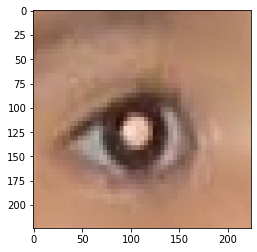

In [62]:
predict_images(model, 'multiclass')

white eye = retinoblastoma ✅

Saving zhZtlzsm4cUp8CNzfl0w2pjrcwJBfbFV_lg copy.jpeg to zhZtlzsm4cUp8CNzfl0w2pjrcwJBfbFV_lg copy.jpeg
Normal


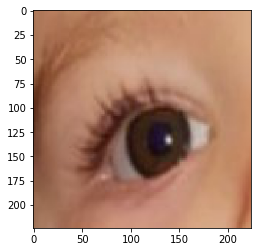

In [18]:
predict_images(model, 'multiclass')

No reflection = Normal ✅

Saving redeye.jpeg to redeye.jpeg
Normal


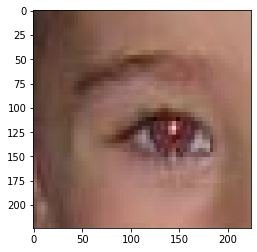

In [63]:
predict_images(model, 'multiclass')

Red eye = Normal ✅

Retinoblastoma


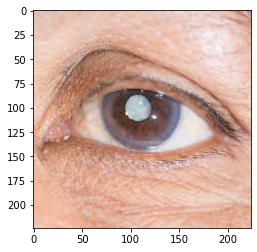

In [35]:
classification_type = 'multiclass'

img = image.load_img('/Users/muhammadhugo/Documents/Bangkit/Model/dataset/dummy/validation/retinoblastoma/images - 2021-05-10T202700.503.jpg', target_size=(224,224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
  
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
    
    #buat ngecek multiclass
if classification_type == 'multiclass':
    if round(float(classes[0][0])) == 1:
        print('Normal')
    elif round(float(classes[0][1])) == 1:
        print('Retinoblastoma')
    
    #buat ngecek binary class
elif classification_type == 'binary':
    if round(float(classes[0])) == 1:
        print('Normal')
    elif round(float(classes[0])) == 0:
        print('Retinoblastoma')

white eye = retinoblastoma ✅

## Save Model

In [ ]:
import pathlib

model.save("model_Basedvgg-3_multiclass.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

# tflite_model_file = pathlib.Path("/content/tflite")
# tflite_model_file.write_bytes(tflite_model)

# Save the model.
with open('model_VGGBased-3_multiclass.tflite', 'wb') as f:
  f.write(tflite_model)